In [1]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy.optimize import curve_fit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import random
from astropy.table import Table, Column
import pandas as pd
import numpy as np
from datetime import datetime
import time

import warnings
warnings.filterwarnings("ignore")

In [2]:
## This function allows to execute the OS commands
def xcmd(cmd, verbose=True):
    """Runs an OS command
    :param cmd: terminal command
    :type cmd: ``str``
    :param verbose: printing the details, default True 
    :type verbose: ``boolean``
    :return: OS outputs
    :rtype: ``str``
    """

    if verbose: print('\n'+cmd)

    tmp=os.popen(cmd)
    output=''
    for x in tmp: output+=x
    if 'abort' in output:
        failure=True
    else:
        failure=tmp.close()
    if False:
        print('execution of %s failed' % cmd)
        print('error is as follows', output)
        sys.exit()
    else:
        return output


In [3]:
# This function works with both dbtable and the catalog header name on EDD
def get_catal(catal_string, infoFile="../bar_files/catalogs_info.dat", bars_folder='../bar_files/'):
    
#     xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/catalogs_info.dat ../bar_files/.", verbose=True)

    with open(infoFile, "r") as f:
        lines = f.readlines()


        try:
            for i, line in enumerate(lines):
                if catal_string in line:
                    
                    while not "begin" in line:
                        i-=1
                        line = lines[i]
                    while not "filename" in line:
                        i+=1
                        line=lines[i]

                    fname_string = line
                    break
        except: 
            return "", []
            
        catal_columns = []
        
        try:
            while not "column" in line:
                i+=1
                line=lines[i]
            while not 'end' in line:
                catal_columns.append(line.split("=>")[1].split("|")[0].strip())
                i+=1
                line=lines[i]
                
        except:
            print("why")
            return "", []


    catal_file_name = fname_string.split("=>")[1].strip("\n").strip("")
    
#     xcmd("scp -r ehsan@arp.ifa.hawaii.edu:~/bar_files/"+catal_file_name+"  "+bars_folder+"/.", verbose=True)
    
    data = pd.read_csv(bars_folder+catal_file_name, names=catal_columns, delimiter='|')
    
    for col in catal_columns:
        if col.upper()=="PGC":
            break
    
    data.rename(columns={col:col.upper()}, inplace=True)
    data = data.set_index('PGC')
    
    # taking care of empty string
    data = data.replace(r'^\s*$', np.nan, regex=True)
    
    if "1PGC" in data.columns:
        data = data.rename(columns={"1PGC": "PGC1"})
    else:
        data["PGC1"] = data.index.values
    
    if "av_flag" in data.columns:
        data = data[data.av_flag==0]
    
    
    return data

In [4]:
def make_data(data, catalogs, catal_data, catal_key, catal_DM="DM", catal_eDM="eDM", delta=0, \
              cols=["Vcmb","Nest"]):
    
    if not catal_key in catalogs and not catal_key in data:
        data[catal_key] = catal_data[["PGC1", catal_DM, catal_eDM]+cols]
        data[catal_key] = data[catal_key].rename(columns={"PGC1": "PGC1_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_DM: "DM_"+catal_key})
        data[catal_key] = data[catal_key].rename(columns={catal_eDM: "eDM_"+catal_key})
        
        for col in cols:
            data[catal_key] = data[catal_key].rename(columns={col: col+"_"+catal_key})
        
        catalogs.append(catal_key)
        
        data[catal_key]["DM_"+catal_key] += delta
        
    else:
        print("This catalog has been already imported ...")
        print("Use a different key than "+catal_key)
    
    return data, catalogs
    

In [5]:
#################################################################
def Vh2V3k(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    v3k = Vh-25.2*cosl*cosb-245.7*sinl*cosb+276.8*sinb

    return v3k

#################################################################

def Vcmb2Vmod(Vcmb, omegam=0.27):
    
    omegal=1.-omegam
    c=299800.
    z=Vcmb/c
    q0=0.5*(omegam-2.*omegal)
    fmod=1.+0.5*(1.-q0)*z-(1./6)*(1.-q0-3.*q0**2+1.)*z**2
    Vmod=c*z*fmod

    return Vmod
#################################################################

def Vh2Vls(el,b, Vh):
  
    alpha = np.pi / 180.
    cosb = np.cos(b*alpha)
    sinb = np.sin(b*alpha)
    cosl = np.cos(el*alpha)
    sinl = np.sin(el*alpha)
    
    vls = Vh-26.*cosl*cosb+317.*sinl*cosb-8.*sinb

    return vls
#################################################################

In [6]:
catalogs = []

def prepare_data(df, catal_name, col_names=None):
    
    cat = catal_name
    
    if col_names is None:
        return df
    else:
        df["DM_"+cat]   = df[col_names[0]]
        df["eDM_"+cat]  = df[col_names[1]]
        df['Vcmb_'+cat] = df[col_names[2]]
       
    df["eDM_"+cat][df["DM_"+cat]==0] = np.nan
    df["DM_"+cat][df["DM_"+cat]==0] = np.nan
    df['PGC1_'+cat] = df.index
    df['PGC1_'+cat][df["DM_"+cat].isna()] = np.nan
    df['Vcmb_'+cat][df["DM_"+cat].isna()] = np.nan
    
    columns = ["DM", "eDM", "PGC1", "Vcmb"]
    
    if not catal_name in catalogs:
        catalogs.append(catal_name)
    
    return df[[col+'_'+cat for col in columns]]

In [7]:
catal_dbtable = "kcf4sniagroup"
catal = get_catal(catal_dbtable)

df = prepare_data(catal, 'SNIa', ['DM', 'eDM', 'gVcmb'])

print(len(catal))
df.head()

945


,DM_SNIa,eDM_SNIa,PGC1_SNIa,Vcmb_SNIa
PGC,,,,
250,35.050,0.130,250,6894
282,36.040,0.110,282,10921
415,35.130,0.140,415,7232
515,34.280,0.150,515,4896
616,36.045,0.115,616,11210


In [8]:
data = pd.read_csv('./allcf4fp_group_bar.221123', delimiter='|')
data = data.rename(columns=lambda x: x.strip())
data = data.set_index('PGC')

data = prepare_data(data, 'FP', ['DM_w', 'eDM', 'gVcmb'])

print(len(data))

df = df.join(data, how='outer')

df.head()

27696


,DM_SNIa,eDM_SNIa,PGC1_SNIa,Vcmb_SNIa,DM_FP,eDM_FP,PGC1_FP,Vcmb_FP
PGC,,,,,,,,
75,NaN,NaN,NaN,NaN,36.463,0.299,75.0,11521.0
115,NaN,NaN,NaN,NaN,36.280,0.520,115.0,14051.0
123,NaN,NaN,NaN,NaN,35.950,0.500,123.0,10964.0
211,NaN,NaN,NaN,NaN,36.136,0.211,211.0,10244.0
250,35.05,0.13,250.0,6894.0,NaN,NaN,NaN,NaN


In [9]:
catal_dbtable = "kcf4tfgroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'TFR', ['DM_w', 'eDM', 'gVcmb'])

print(len(data))

df = df.join(data, how='outer')

df.head()

10188


,DM_SNIa,eDM_SNIa,PGC1_SNIa,Vcmb_SNIa,DM_FP,eDM_FP,PGC1_FP,Vcmb_FP,DM_TFR,eDM_TFR,PGC1_TFR,Vcmb_TFR
PGC,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,12.0,6179.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,14.0,11474.0
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,16.0,5354.0
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,55.0,4466.0
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.22,0.41,63.0,8404.0


In [10]:
catal_dbtable = "kcf4sbfgroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'SBFm', ['DMm_w', 'eDMm', 'gVcmb'])
data = data.dropna()
print(len(data))

df = df.join(data, how='outer')

df.head()

177


,DM_SNIa,eDM_SNIa,PGC1_SNIa,Vcmb_SNIa,DM_FP,eDM_FP,PGC1_FP,Vcmb_FP,DM_TFR,eDM_TFR,PGC1_TFR,Vcmb_TFR,DM_SBFm,eDM_SBFm,PGC1_SBFm,Vcmb_SBFm
PGC,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,12.0,6179.0,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,14.0,11474.0,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,16.0,5354.0,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,55.0,4466.0,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.22,0.41,63.0,8404.0,NaN,NaN,NaN,NaN


In [11]:
catal_dbtable = "kcf4sbfgroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'SBFir', ['DMir_w', 'eDMir', 'gVcmb'])
data = data.dropna()
print(len(data))

df = df.join(data, how='outer')

df.head()

57


,DM_SNIa,eDM_SNIa,PGC1_SNIa,Vcmb_SNIa,DM_FP,eDM_FP,PGC1_FP,Vcmb_FP,DM_TFR,eDM_TFR,PGC1_TFR,Vcmb_TFR,DM_SBFm,eDM_SBFm,PGC1_SBFm,Vcmb_SBFm,DM_SBFir,eDM_SBFir,PGC1_SBFir,Vcmb_SBFir
PGC,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,12.0,6179.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,14.0,11474.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,16.0,5354.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,55.0,4466.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.22,0.41,63.0,8404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
catal_dbtable = "kcf4sniigroup"
catal = get_catal(catal_dbtable)

data = prepare_data(catal, 'SNII', ['DM', 'eDM', 'Vcmb'])

print(len(data))

df = df.join(data, how='outer')

df.head()

94


,DM_SNIa,eDM_SNIa,PGC1_SNIa,Vcmb_SNIa,DM_FP,eDM_FP,PGC1_FP,Vcmb_FP,DM_TFR,eDM_TFR,...,PGC1_SBFm,Vcmb_SBFm,DM_SBFir,eDM_SBFir,PGC1_SBFir,Vcmb_SBFir,DM_SNII,eDM_SNII,PGC1_SNII,Vcmb_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.97,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,36.07,0.38,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.63,0.45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.22,0.39,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35.22,0.41,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
catalogs

['SNIa', 'FP', 'TFR', 'SBFm', 'SBFir', 'SNII']

In [14]:
ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat, "DM_"+cat, "eDM_"+cat, "Vcmb_"+cat]

df = df[ss]

ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]

print(len(df))

df.head()

37832


,PGC1_SNIa,DM_SNIa,eDM_SNIa,Vcmb_SNIa,PGC1_FP,DM_FP,eDM_FP,Vcmb_FP,PGC1_TFR,DM_TFR,...,Vcmb_SBFm,PGC1_SBFir,DM_SBFir,eDM_SBFir,Vcmb_SBFir,PGC1_SNII,DM_SNII,eDM_SNII,Vcmb_SNII,pgc1
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,34.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,36.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,34.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,34.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,35.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0


In [15]:
df = df.astype('float64')

df.head()

,PGC1_SNIa,DM_SNIa,eDM_SNIa,Vcmb_SNIa,PGC1_FP,DM_FP,eDM_FP,Vcmb_FP,PGC1_TFR,DM_TFR,...,Vcmb_SBFm,PGC1_SBFir,DM_SBFir,eDM_SBFir,Vcmb_SBFir,PGC1_SNII,DM_SNII,eDM_SNII,Vcmb_SNII,pgc1
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,34.97,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,36.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,34.63,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,34.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,35.22,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0


In [16]:
ss = []
for cat in catalogs:
    ss += ['PGC1_'+cat]   
df['pgc1'] = df[ss].median(axis=1)
df = df[~df['pgc1'].isna()]



d = np.zeros(len(catalogs))
myDict = {}
for i, cat in enumerate(catalogs):
    myDict[cat] = d[i]

for cat in catalogs:
    df['w_'+cat] = 1./df['eDM_'+cat]**2
    df['xw_'+cat] = (df['DM_'+cat]+myDict[cat])*df['w_'+cat]

  
dg = df.groupby("pgc1").agg(["sum", "count"])

for cat in catalogs:
    dg['eDMg_'+cat] = np.sqrt(1./dg['w_'+cat]['sum'])
    dg['DMg_'+cat] = (dg['xw_'+cat]['sum'])/dg['w_'+cat]['sum']

ss = []
for cat in catalogs:
    dg['N_'+cat] = dg["DM_"+cat]['count']
    ss += ['N_'+cat, "DMg_"+cat, "eDMg_"+cat]

dg = dg[ss]
dg.replace([np.inf, -np.inf], np.nan, inplace=True)

dg.index = dg.index.astype('int')


ss = ['DMg_'+cat for cat in catalogs]+['eDMg_'+cat for cat in catalogs]
dg_ = dg[ss]

for cat in catalogs:
        dg_['gw_'+cat] = 1./dg_['eDMg_'+cat]**2

In [17]:
# dg = df.groupby("pgc1").agg(["sum", "count"])
dg

,N_SNIa,DMg_SNIa,eDMg_SNIa,N_FP,DMg_FP,eDMg_FP,N_TFR,DMg_TFR,eDMg_TFR,N_SBFm,DMg_SBFm,eDMg_SBFm,N_SBFir,DMg_SBFir,eDMg_SBFir,N_SNII,DMg_SNII,eDMg_SNII
,,,,,,,,,,,,,,,,,,
pgc1,,,,,,,,,,,,,,,,,,
12,0,NaN,NaN,0,NaN,NaN,1,34.97,0.41,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
14,0,NaN,NaN,0,NaN,NaN,1,36.07,0.38,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
16,0,NaN,NaN,0,NaN,NaN,1,34.63,0.45,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
55,0,NaN,NaN,0,NaN,NaN,1,34.22,0.39,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
63,0,NaN,NaN,0,NaN,NaN,1,35.22,0.41,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003281,1,37.63,0.10,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
9003283,1,35.05,0.10,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN


In [18]:
for col in catalogs[1:]:
    df0 = dg[["DMg_SNIa", "DMg_"+col]].dropna()

    delta = df0.DMg_SNIa - df0["DMg_"+col]

    print(col, np.median(delta))

FP 0.12949999999999662
TFR 0.14999999999999858
SBFm 0.045000000000001705
SBFir 0.10499999999999687
SNII 0.059999999999996945


In [19]:
def GfastChi2(dg, theta=None):
    
    if theta is None:
        d = np.zeros(len(catalogs))
    else:
        theta = np.asarray(theta)
        d = np.concatenate((np.zeros(1), theta[1:]))
    
    myDict = {}
    for i, cat in enumerate(catalogs):
        myDict[cat] = d[i]

    ###########################################################
        
    for cat in catalogs:
#         dg['gw_'+cat] = 1./dg['eDMg_'+cat]**2
        dg['gxw_'+cat] = (dg['DMg_'+cat]+myDict[cat])*dg['gw_'+cat]


    sx = ['gxw_'+cat for cat in catalogs]
    sw = ['gw_'+cat for cat in catalogs]
    
    ERRave2 = 1./dg[sw].sum(axis=1)
    ave = dg[sx].sum(axis=1)*ERRave2
    
    myDict[catalogs[0]] = theta[0]
    for cat in catalogs:
        dg['gxi2_'+cat] = ((dg['DMg_'+cat]+myDict[cat]-ave)**2)/(dg_['eDMg_'+cat]**2+ERRave2)


    sxi = ['gxi2_'+cat for cat in catalogs]    
    XI2 = dg[sxi].sum(axis=1)

    return XI2.sum()

In [20]:
t1 =  datetime.now()

print(GfastChi2(dg_, theta=range(len(catalogs))))

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

39108.91478857294
Execution time:
0:00:00.079526


In [21]:
dg.head()

,N_SNIa,DMg_SNIa,eDMg_SNIa,N_FP,DMg_FP,eDMg_FP,N_TFR,DMg_TFR,eDMg_TFR,N_SBFm,DMg_SBFm,eDMg_SBFm,N_SBFir,DMg_SBFir,eDMg_SBFir,N_SNII,DMg_SNII,eDMg_SNII
,,,,,,,,,,,,,,,,,,
pgc1,,,,,,,,,,,,,,,,,,
12,0,NaN,NaN,0,NaN,NaN,1,34.97,0.41,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
14,0,NaN,NaN,0,NaN,NaN,1,36.07,0.38,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
16,0,NaN,NaN,0,NaN,NaN,1,34.63,0.45,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
55,0,NaN,NaN,0,NaN,NaN,1,34.22,0.39,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN
63,0,NaN,NaN,0,NaN,NaN,1,35.22,0.41,0,NaN,NaN,0,NaN,NaN,0,NaN,NaN


In [22]:
df

,PGC1_SNIa,DM_SNIa,eDM_SNIa,Vcmb_SNIa,PGC1_FP,DM_FP,eDM_FP,Vcmb_FP,PGC1_TFR,DM_TFR,...,w_FP,xw_FP,w_TFR,xw_TFR,w_SBFm,xw_SBFm,w_SBFir,xw_SBFir,w_SNII,xw_SNII
PGC,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.0,34.97,...,NaN,NaN,5.948840,208.030934,NaN,NaN,NaN,NaN,NaN,NaN
14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.0,36.07,...,NaN,NaN,6.925208,249.792244,NaN,NaN,NaN,NaN,NaN,NaN
16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.0,34.63,...,NaN,NaN,4.938272,171.012346,NaN,NaN,NaN,NaN,NaN,NaN
55,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,34.22,...,NaN,NaN,6.574622,224.983563,NaN,NaN,NaN,NaN,NaN,NaN
63,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,63.0,35.22,...,NaN,NaN,5.948840,209.518144,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9003281,9003281.0,37.63,0.10,21964.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9003283,9003283.0,35.05,0.10,7034.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9003286,9003286.0,37.95,0.10,25533.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
len(dg_)

37832

In [24]:
dg_.head()

,DMg_SNIa,DMg_FP,DMg_TFR,DMg_SBFm,DMg_SBFir,DMg_SNII,eDMg_SNIa,eDMg_FP,eDMg_TFR,eDMg_SBFm,...,gxw_TFR,gxw_SBFm,gxw_SBFir,gxw_SNII,gxi2_SNIa,gxi2_FP,gxi2_TFR,gxi2_SBFm,gxi2_SBFir,gxi2_SNII
,,,,,,,,,,,...,,,,,,,,,,
pgc1,,,,,,,,,,,,,,,,,,,,,
12,NaN,NaN,34.97,NaN,NaN,NaN,NaN,NaN,0.41,NaN,...,219.928614,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
14,NaN,NaN,36.07,NaN,NaN,NaN,NaN,NaN,0.38,NaN,...,263.642659,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
16,NaN,NaN,34.63,NaN,NaN,NaN,NaN,NaN,0.45,NaN,...,180.888889,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
55,NaN,NaN,34.22,NaN,NaN,NaN,NaN,NaN,0.39,NaN,...,238.132807,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN
63,NaN,NaN,35.22,NaN,NaN,NaN,NaN,NaN,0.41,NaN,...,221.415824,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN


In [25]:
def lnlike(theta):
    
    xi2 = GfastChi2(dg_, theta=theta)
    
    return -0.5*xi2


def lnprior(theta):
    
    return 0.0


def lnprob(theta):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta)

In [26]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = len(catalogs), 128 # 128

p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)

sampler.reset()
sampler.run_mcmc(p0, 5000) # 5000 for hours
samples = sampler.chain[:, 1000:, :].reshape((-1, ndim))

theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))



Execution time:
6:02:59.703688


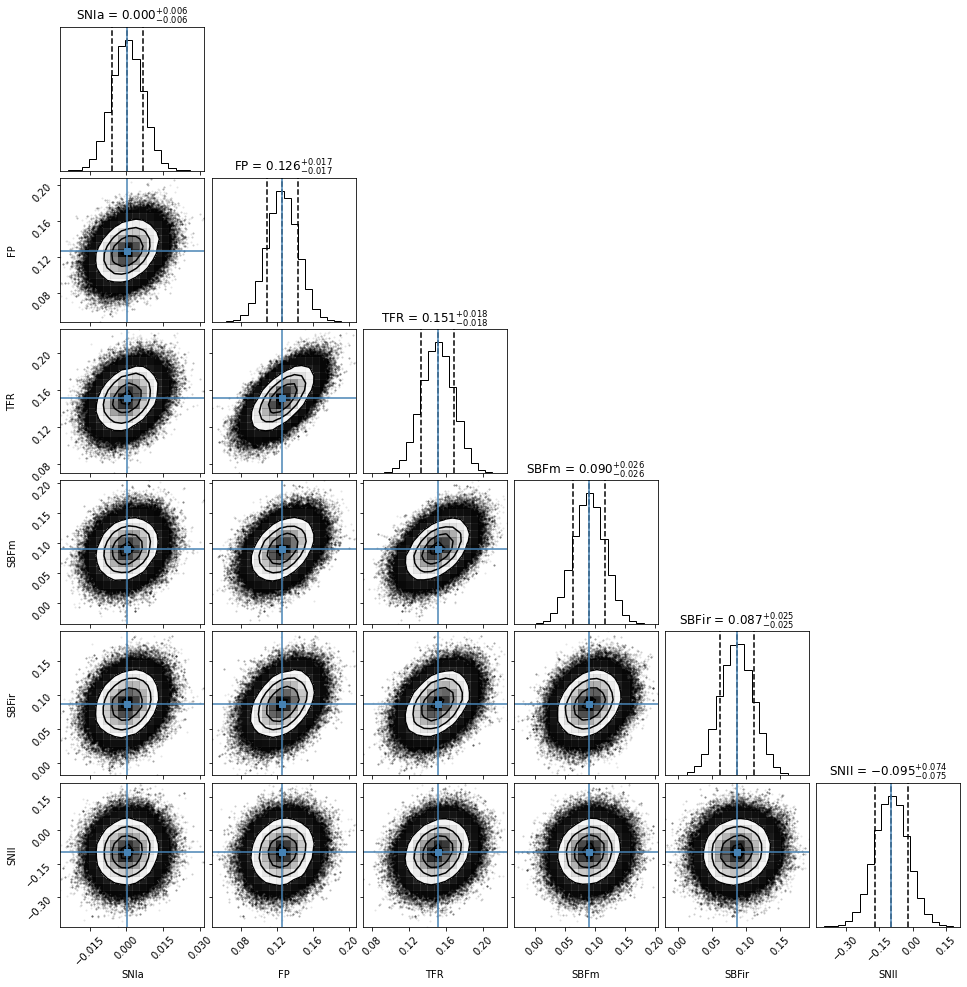

In [27]:
truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=catalogs, 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")

###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

In [28]:
npzName = "ALL_groups_wo_hc_updatedFP_erratum_20221123.npz"
np.savez(npzName, samples)
npzfile = np.load(npzName)
print("npz attributes: ", npzfile.files)
NPZsamples = npzfile['arr_0']

npz attributes:  ['arr_0']


In [29]:
mean = np.mean(NPZsamples[:,0])

mean

0.0003349428854687136

In [30]:
NPZsamples[:,0] -= mean

In [31]:
theta = map(lambda v: [v[1], v[2]-v[1], v[1]-v[0]],
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))



theta

In [32]:
labs  = ['SNIa', 'FP', 'TFR', 'SBF_{main}', 'SBF_{ir}', 'SNII']

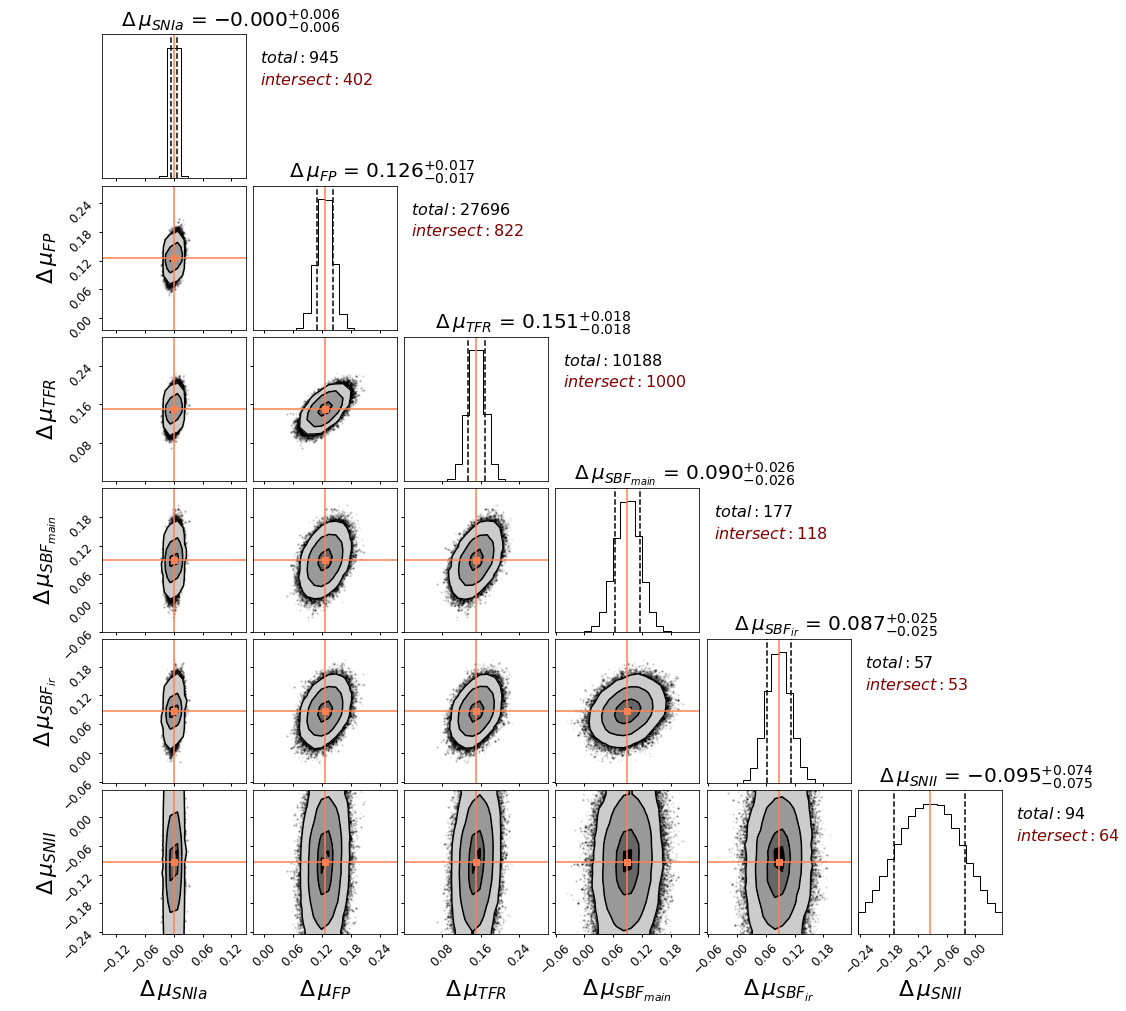

In [33]:
theta = map(lambda v: [v[1], v[2]-v[1], v[1]-v[0]],
                            zip(*np.percentile(NPZsamples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
truths[0] = 0

labels = ['                  '+r'$\Delta\/ \mu_{'+cat+'}$' for cat in labs] 

fig = corner.corner(NPZsamples, labels=labels, 
                    truths=truths, truth_color='coral',
                    levels=(1-np.exp(-1./8),1-np.exp(-0.5),1-np.exp(-0.5*4),1-np.exp(-0.5*9)),
                    show_titles=True, fill_contours=True, plot_density=True,
                    quantiles=[0.16, 0.84], 
                    scale_hist=False,space=0, 
                    title_kwargs={"fontsize": 20}, 
                    title_fmt=".3f",
                    range=[(t-0.15,t+0.15) for t in truths]
                   )

m = 0 
n_cat = len(catalogs)
i_cat = 0
for ax in fig.get_axes():
    ax.tick_params(axis='both', labelsize=12)
    
    lbl = ax.xaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)
    lbl.set_linespacing(50)
    lbl = ax.yaxis.get_label()
    lbl.set_fontsize(22)
    txt = lbl.get_text().strip()
    lbl.set_text(txt)    
    
    
    ax.tick_params(which='major', length=3, width=1., direction='out')
    
    Ylm = ax.get_ylim() ; Xlm = ax.get_xlim()
    x0 = -0.1*Xlm[0]+1.1*Xlm[1]
    
    if m%(n_cat+1)==0:
        y0 = 0.2*Ylm[0]+0.80*Ylm[1]
        dx = df[['DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$total: $"+str(len(dx)), fontsize=16, color='k')
        
        y0 = 0.35*Ylm[0]+0.65*Ylm[1]
        other_DMs = ["DM_"+c for c in catalogs if c != catalogs[i_cat]]
        
        df["sumDM"] = df[other_DMs].sum(axis=1)
        df["sumDM"][df["sumDM"]==0] = np.nan
        
        dx = df[['sumDM', 'DM_'+catalogs[i_cat]]].dropna()
        ax.text(x0,y0, r"$intersect: $"+str(len(dx)), fontsize=16, color='maroon')
        i_cat += 1


    m+=1

